In [24]:
# import libraries
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import ParameterGrid

# from sklearn.model_selection import TimeSeriesSplit

In [2]:
# Use seaborn style defaults and set the default figure size
sns.set(rc={'figure.figsize':(11, 4)})
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)

## Load and merge datasets

In [3]:
dataset = pd.read_csv("../data/train.csv", names=['Store','Dept','Date','weeklySales','isHoliday'],sep=',', header=0)
features = pd.read_csv("../data/features.csv",sep=',', header=0,
                       names=['Store','Date','Temperature','Fuel_Price','MarkDown1','MarkDown2','MarkDown3','MarkDown4',
                              'MarkDown5','CPI','Unemployment','IsHoliday']).drop(columns=['IsHoliday'])
stores = pd.read_csv("../data/stores.csv", names=['Store','Type','Size'],sep=',', header=0)
dataset = dataset.merge(stores, how='left').merge(features, how='left')

## Select the important features

In [4]:
features_to_keep = ['Store','Dept','Date','weeklySales','isHoliday','CPI','Temperature']
for c in dataset.columns:
    if c not in features_to_keep:
        dataset.drop(c,inplace=True,axis=1)

In [5]:
dataset['Date'] = pd.to_datetime(dataset['Date'])
dataset['isHoliday'] = dataset['isHoliday'].map({True: 1, False: 0})

## Prophet modeling

### Store 5 and Dept 5

In [6]:
dataset_S5_D5 = dataset[(dataset['Store']==5) & (dataset['Dept']==5)]

### Prepare the data for prophet

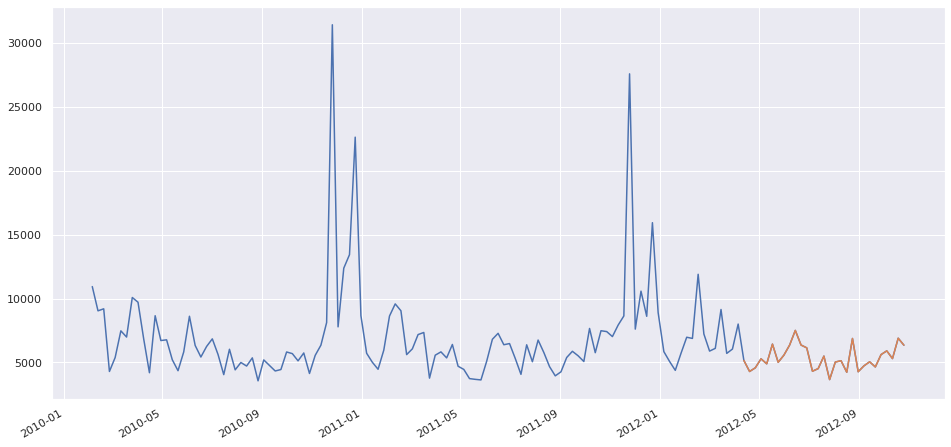

In [7]:
df_prophet = pd.DataFrame()
df_prophet['ds'] = dataset_S5_D5['Date']
df_prophet['y'] = dataset_S5_D5['weeklySales']
df_prophet.reset_index(inplace=True)
df_prophet.drop('index',axis=1,inplace=True)

# Test/Train split
split = 0.2
n_train = int(df_prophet.shape[0]*.8)
df_prophet['isTest'] = 0
df_prophet.loc[n_train:,['isTest']] = 1

# Plot the train and test
fig,ax = plt.subplots(figsize=(16,8))
ax.plot(df_prophet['ds'],df_prophet['y'])
ax.plot(df_prophet[df_prophet['isTest']==1]['ds'],df_prophet[df_prophet['isTest']==1]['y'])
fig.autofmt_xdate()
# sns.lineplot(data=df_prophet,x='ds',y='y',hue='isTest')

In [8]:
class model():
    
    def __init__(self):
        self.model = Prophet()
        
    def fit(self, train):
        self.model.fit(train)
        
    def predict(self, test):
        return self.model.predict(test)
    
    def plot(self, pred):
        return self.model.plot(pred)

In [9]:
# Fit a default prophet model    
m = model()
m.fit(df_prophet[df_prophet['isTest']==0])
df_prophet_pred = m.predict(df_prophet[df_prophet['isTest']==1])

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


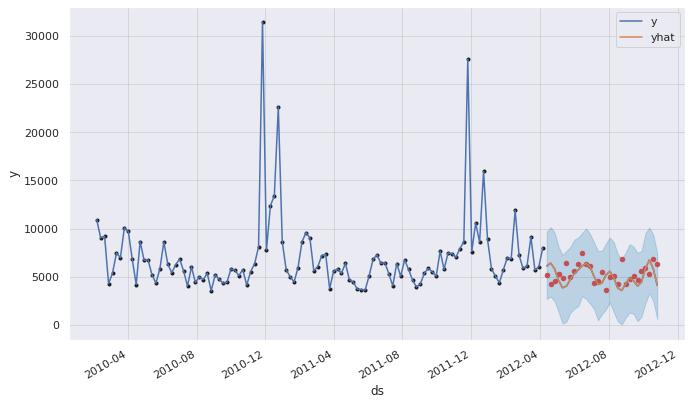

In [10]:
# Plot the train and test
fig = m.plot(df_prophet_pred)
ax = fig.gca()
df_prophet[df_prophet['isTest']==0].plot(x='ds',y='y',ax=ax)
df_prophet[df_prophet['isTest']==1].plot.scatter(x='ds',y='y',c='r',ax=ax)
df_prophet_pred.plot(x='ds',y='yhat',ax=ax)

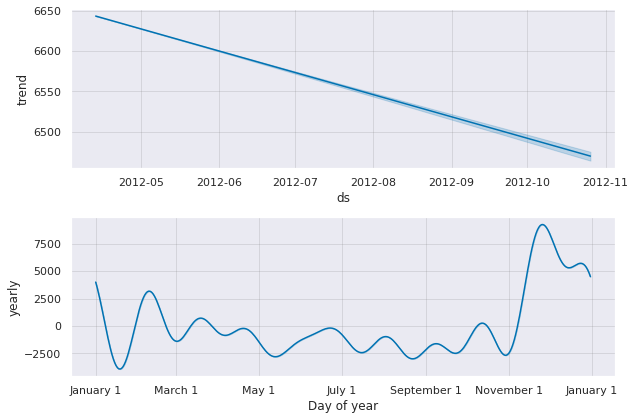

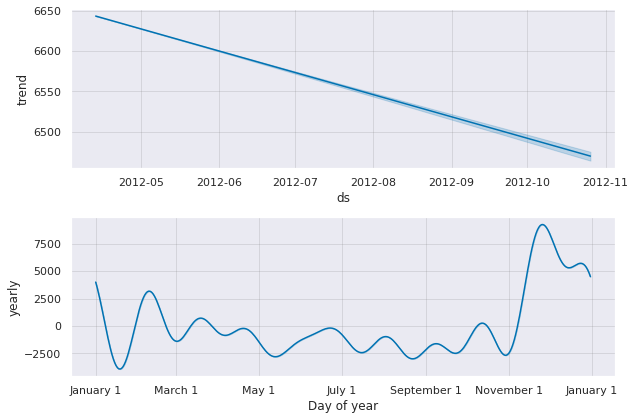

In [11]:
m.model.plot_components(df_prophet_pred)

#### Error measure

In [12]:
y_pred = df_prophet_pred['yhat'].values
y_true = df_prophet[df_prophet['isTest']==1]['y'].values
print('mean absolute error =',mean_absolute_error(y_true=y_true, y_pred=y_pred))

mean absolute error = 912.7813557890104


### Adding Holidays

In [13]:
df_holidays = dataset_S5_D5[dataset_S5_D5['isHoliday']==1][['Date']]
df_holidays.rename(columns={'Date':'ds'}, inplace=True)
df_holidays['holiday'] = 'holiday'
df_holidays['lower_window'] = -1
df_holidays['upper_window'] = 0

In [14]:
m = Prophet(holidays=df_holidays)
m.fit(df_prophet[df_prophet['isTest']==0])
df_prophet_pred = m.predict(df_prophet[df_prophet['isTest']==1])

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


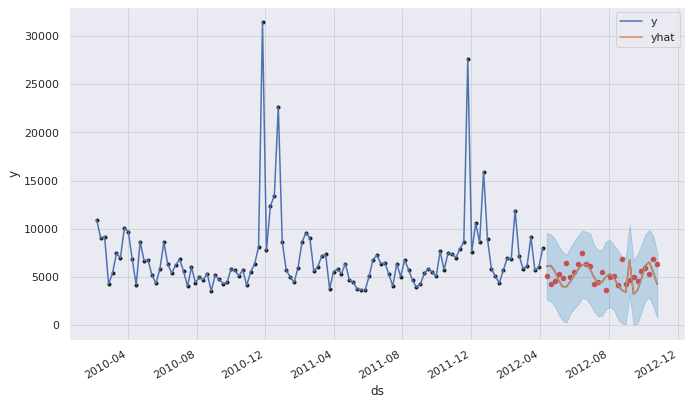

In [15]:
# Plot the train and test
fig = m.plot(df_prophet_pred)
ax = fig.gca()
df_prophet[df_prophet['isTest']==0].plot(x='ds',y='y',ax=ax)
df_prophet[df_prophet['isTest']==1].plot.scatter(x='ds',y='y',c='r',ax=ax)
df_prophet_pred.plot(x='ds',y='yhat',ax=ax)

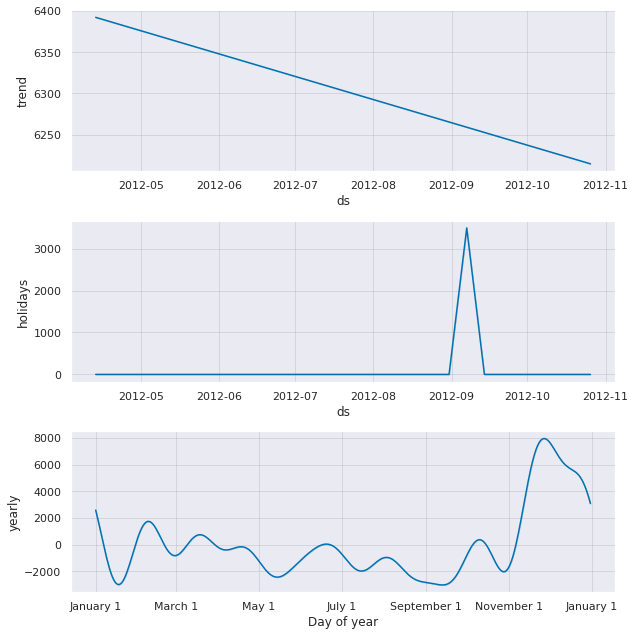

In [16]:
fig = m.plot_components(df_prophet_pred)

In [17]:
y_pred = df_prophet_pred['yhat'].values
y_true = df_prophet[df_prophet['isTest']==1]['y'].values
print('mean absolute error =',mean_absolute_error(y_true=y_true, y_pred=y_pred))

mean absolute error = 1008.2647667376972


### Adding regressors

All NaN here but this the way to do it

In [18]:
# df_prophet['Temperature'] = dataset_S5_D5['Temperature']

# m = Prophet()
# m.add_regressor('Temperature')
# m.fit(df_prophet[df_prophet['isTest']==0])
# df_prophet_pred = m.predict(df_prophet[df_prophet['isTest']==1])

## Hyperparameter tuning

In [26]:
params_grid = {'seasonality_mode':('multiplicative','additive'),
               'changepoint_prior_scale':np.linspace(0,.5,6),
              'holidays_prior_scale':np.linspace(0,.5,6),
              'n_changepoints' : [100,150,200]}
grid = ParameterGrid(params_grid)
# print('Total Possible Models',cnt)

In [32]:
## TODO
# strt='2019-12-31'
# end='2020-02-26'
# model_parameters = pd.DataFrame(columns = ['MAPE','Parameters'])
# for p in grid:
#     test = pd.DataFrame()
#     print(p)
#     random.seed(0)
#     train_model =Prophet(changepoint_prior_scale = p['changepoint_prior_scale'],
#                          holidays_prior_scale = p['holidays_prior_scale'],
#                          n_changepoints = p['n_changepoints'],
#                          seasonality_mode = p['seasonality_mode'],
#                          weekly_seasonality=True,
#                          daily_seasonality = True,
#                          yearly_seasonality = True,
#                          holidays=holiday, 
#                          interval_width=0.95)
#     train_model.add_country_holidays(country_name='US')
#     train_model.fit(X_tr)
#     train_forecast = train_model.make_future_dataframe(periods=57, freq='D',include_history = False)
#     train_forecast = train_model.predict(train_forecast)
#     test=train_forecast[['ds','yhat']]
#     Actual = df[(df['ds']>strt) & (df['ds']<=end)]
#     MAPE = mean_absolute_percentage_error(Actual['y'],abs(test['yhat']))
#     print('Mean Absolute Percentage Error(MAPE)------------------------------------',MAPE)
#     model_parameters = model_parameters.append({'MAPE':MAPE,'Parameters':p},ignore_index=True)